In [1]:
import pandas as pd
import os
import shutil
import yaml
from pathlib import Path
import ast
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from PIL import Image
from typing import List, Tuple, Dict
from tqdm.notebook import tqdm
import random

In [2]:
emory = pd.read_csv('emory_final.csv')

In [3]:
emory = emory[~emory.category.isnull()].reset_index(drop=True)

In [4]:
emory = emory.rename(columns={'Image_Paths':'image_path'})
emory['image_path'] = emory['image_path'].str.replace(r'^../', '', regex=True)
emory = emory.rename(columns={'asses': 'breast_birads', 'ViewPosition':'view','ImageLateralityFinal':'laterality'})

In [5]:
find_emory = emory[emory['num_roi']!=0].reset_index(drop=True)

In [6]:
def display_images(data, idx):
    
    # Set the plot size
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30, 10))
    axes = axes.ravel()

    for i, row in enumerate(data.iloc[idx].itertuples()):
        # Build image path
        img_file_path = row.image_path

        # Open and show image
        if os.path.exists(img_file_path):
            img = Image.open(img_file_path)
            for roi in ast.literal_eval(row.ROI_coords):
                y1, x1, y2, x2 = roi
                try:
                    axes[i].imshow(img, cmap='gray')

                    # Draw bounding box
                    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
                    axes[i].add_patch(rect)
                except Exception as e:
                    print(f"Cannot Display {img_file_path}, because of error:{e}")
                    break
        else:
            axes[i].text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
        
        # Set title with image attributes
        title_text = f"{i} Desc: {row.desc}   Findings {row.findings}"
        axes[i].set_title(title_text, fontsize=8)
        # axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

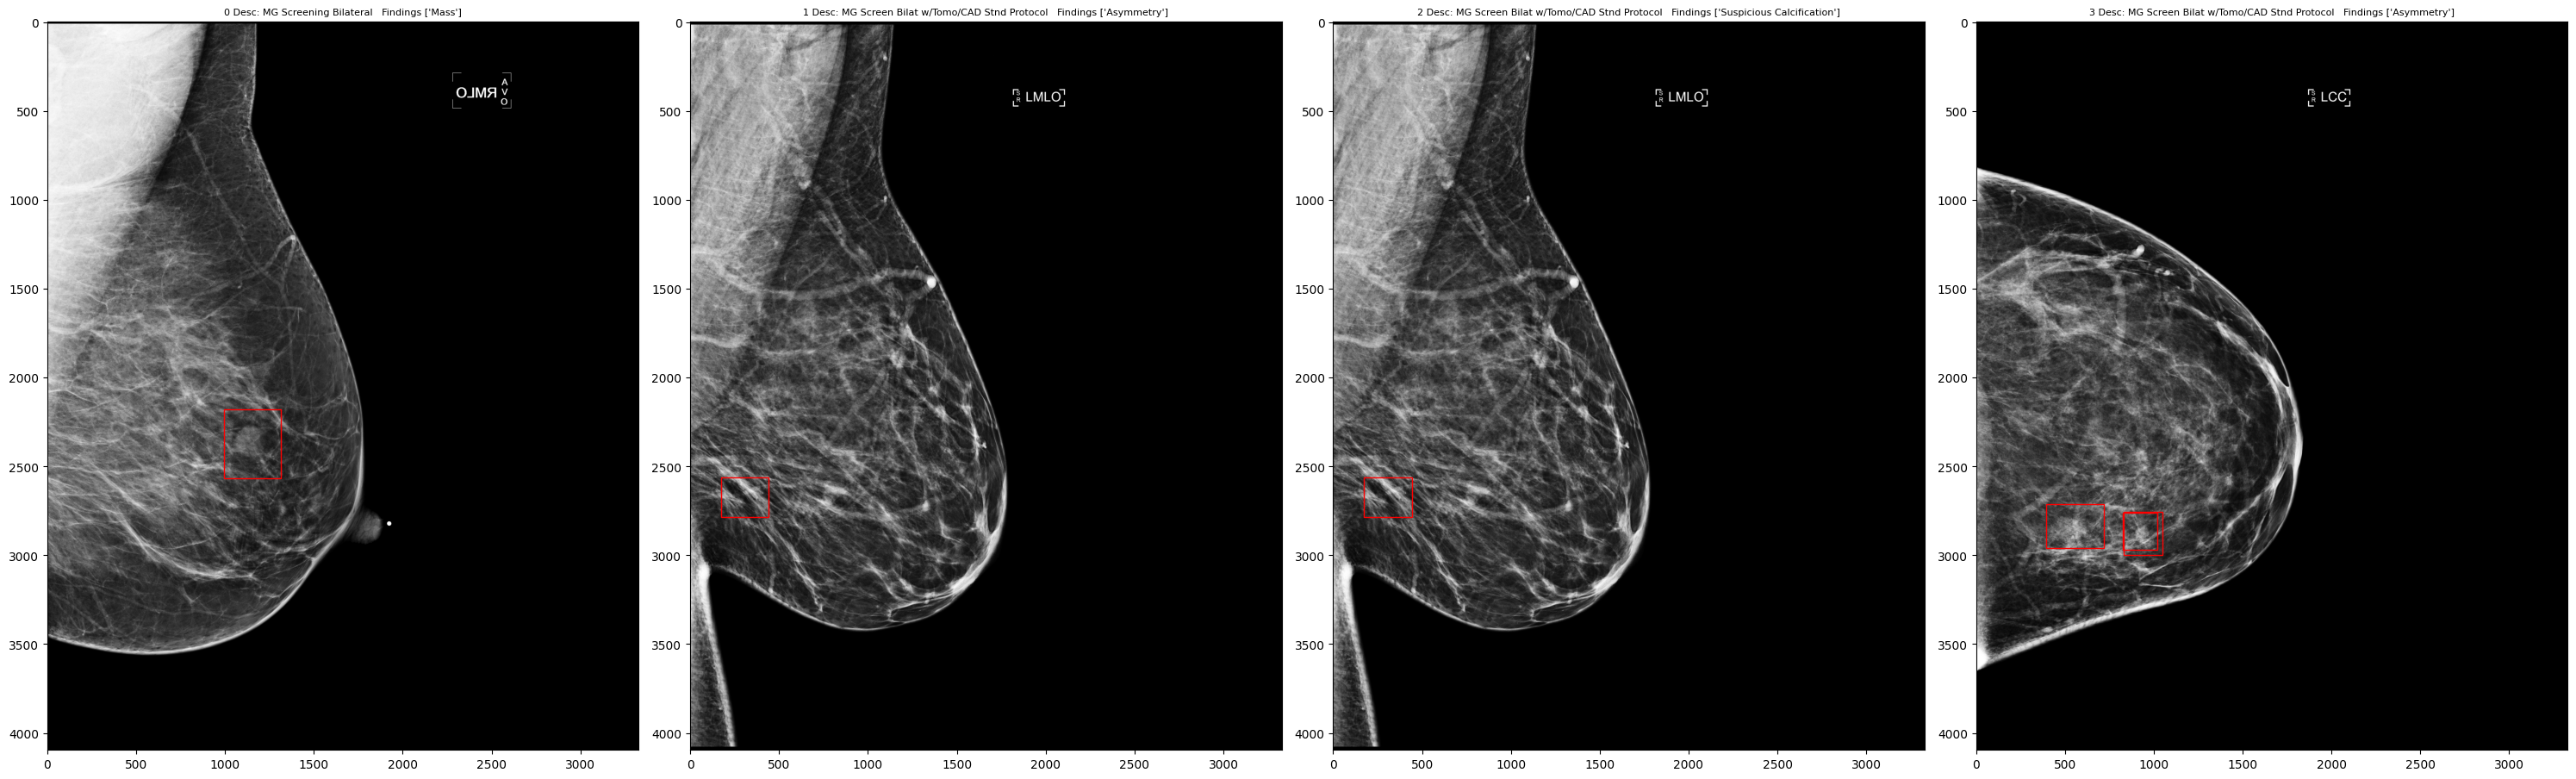

In [7]:
# idx =  random.sample(range(find_emory.shape[0]), 4)
idx = [4,5,6,7]
display_images(find_emory, idx)

## Let's Extract Breast Regions

In [8]:
import torch
import cv2
import numpy as np
from PIL import Image

def torch_CountUpContinuingOnes(b_arr):
    left = torch.arange(len(b_arr))
    left[b_arr > 0] = 0
    left = torch.cummax(left, dim=-1)[0]

    rev_arr = torch.flip(b_arr, [-1])
    right = torch.arange(len(rev_arr))
    right[rev_arr > 0] = 0
    right = torch.cummax(right, dim=-1)[0]
    right = len(rev_arr) - 1 - torch.flip(right, [-1])

    return right - left - 1

def torch_ExtractBreast_with_padding_single_side(img_ori, target_size=(512, 512), padding=1):
    # Detect background and set to zero
    img = torch.where(img_ori <= 20, torch.zeros_like(img_ori), img_ori)
    height, _ = img.shape

    # Extract the main breast region (same as before)
    y_a = height // 2 + int(height * 0.4)
    y_b = height // 2 - int(height * 0.4)
    b_arr = img[y_b:y_a].to(torch.float32).std(dim=0) != 0
    continuing_ones = torch_CountUpContinuingOnes(b_arr)
    col_ind = torch.where(continuing_ones == continuing_ones.max())[0]
    img = img[:, col_ind]

    _, width = img.shape
    x_a = width // 2 + int(width * 0.4)
    x_b = width // 2 - int(width * 0.4)
    b_arr = img[:, x_b:x_a].to(torch.float32).std(dim=1) != 0
    continuing_ones = torch_CountUpContinuingOnes(b_arr)
    row_ind = torch.where(continuing_ones == continuing_ones.max())[0]
    breast_region = img_ori[row_ind][:, col_ind]

    # Resize the extracted breast region while maintaining the aspect ratio
    breast_height, breast_width = breast_region.shape
    aspect_ratio = breast_width / breast_height

    # Define target dimensions based on aspect ratio
    if aspect_ratio > 1:
        # Wider than tall
        new_width = target_size[1] - padding
        new_height = int(new_width / aspect_ratio)
    else:
        # Taller than wide
        new_height = target_size[0] - padding
        new_width = int(new_height * aspect_ratio)

    resized_breast = cv2.resize(breast_region.cpu().numpy(), (new_width, new_height))
    resized_breast = torch.from_numpy(resized_breast)

    # Determine which side has lower intensity
    pad_x = target_size[1] - new_width
    pad_y = target_size[0] - new_height

    # Initialize offsets
    x_offset = 0
    y_offset = 0
    left_intensity = 0
    right_intensity = 0
    top_intensity = 0
    bottom_intensity = 0

    # Decide padding side for x-axis
    if pad_x > 0:
        left_intensity = resized_breast[:, 0].mean()
        right_intensity = resized_breast[:, -1].mean()
        if left_intensity < right_intensity:
            # Pad on the left side
            x_offset = pad_x
        else:
            # Pad on the right side
            x_offset = 0

    # Decide padding side for y-axis
    if pad_y > 0:
        top_intensity = resized_breast[0, :].mean()
        bottom_intensity = resized_breast[-1, :].mean()
        if top_intensity < bottom_intensity:
            # Pad on the top side
            y_offset = pad_y
        else:
            # Pad on the bottom side
            y_offset = 0

    # Create a padded image with the target size and place the resized breast region
    padded_img = torch.zeros(target_size, dtype=resized_breast.dtype)
    padded_img[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_breast
    
    data = {'padded_img':padded_img,
            'breast_region': breast_region,
            'left_intensity': left_intensity,
            'right_intensity': right_intensity,
            'top_intensity': top_intensity,
            'bottom_intensity': bottom_intensity,
            'target_size': target_size,
            'padding': padding
           }

    return data

# Apply the function in display_grid_transform for Emory dataset


In [9]:
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_img = clahe.apply(image)
    return equalized_img

def mean_variance_normalization(img_torch):
    img_min, img_max = img_torch.min(), img_torch.max()
    img_torch = (img_torch - img_min) / (img_max - img_min) * 255
    return img_torch

def transform_bbox(original_bbox, data):
    """
    Transform bounding box coordinates from original image space to resized and padded space.
    
    Args:
        original_bbox (tuple): (x1, y1, x2, y2) in original image space (3500x2680)
    Returns:
        tuple: Transformed (x1, y1, x2, y2) coordinates in the new image space
    """
    orig_x1, orig_y1, orig_x2, orig_y2 = original_bbox
    
    breast_region_shape = data['breast_region'].shape
    breast_height, breast_width = breast_region_shape
    target_size = data['target_size']
    padding = data['padding']
    left_intensity = data['left_intensity']
    right_intensity = data['right_intensity']
    top_intensity = data['top_intensity']
    bottom_intensity = data['bottom_intensity']
    
    # Calculate aspect ratio of the breast region
    aspect_ratio = breast_width / breast_height
    
    # Determine the dimensions after resize (before padding)
    if aspect_ratio > 1:
        # Wider than tall
        new_width = target_size[1] - padding
        new_height = int(new_width / aspect_ratio)
    else:
        # Taller than wide
        new_height = target_size[0] - padding
        new_width = int(new_height * aspect_ratio)
    
    # Calculate scaling factors
    scale_x = new_width / breast_width
    scale_y = new_height / breast_height
    
    # Scale the bbox coordinates
    scaled_x1 = int(orig_x1 * scale_x)
    scaled_y1 = int(orig_y1 * scale_y)
    scaled_x2 = int(orig_x2 * scale_x)
    scaled_y2 = int(orig_y2 * scale_y)
    
    # Calculate padding offsets based on image dimensions
    pad_x = target_size[1] - new_width
    pad_y = target_size[0] - new_height
    
    # Get the intensity values from the edges of the breast region
    # You'll need to pass these values or compute them here
    # For now, we'll assume they're computed the same way as in your original function
    x_offset = pad_x if left_intensity < right_intensity else 0
    y_offset = pad_y if top_intensity < bottom_intensity else 0
    
    # Apply offsets to the scaled coordinates
    final_x1 = scaled_x1 + x_offset
    final_y1 = scaled_y1 + y_offset
    final_x2 = scaled_x2 + x_offset
    final_y2 = scaled_y2 + y_offset
    
    # Ensure coordinates are within bounds
    final_x1 = max(0, min(final_x1, target_size[1]-1))
    final_y1 = max(0, min(final_y1, target_size[0]-1))
    final_x2 = max(0, min(final_x2, target_size[1]-1))
    final_y2 = max(0, min(final_y2, target_size[0]-1))
    
    return (final_x1, final_y1, final_x2, final_y2)

In [10]:
def display_image_transform(data, idx):
    # Set the plot size
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30, 10))
    axes = axes.ravel()

    for i, row in enumerate(data.iloc[idx].itertuples()):
        # Build image path
        img_file_path = row.image_path

        # Open and show image
        if os.path.exists(img_file_path):
            img_np = cv2.imread(img_file_path, cv2.IMREAD_GRAYSCALE)
            
            img_torch = torch.from_numpy(img_np).to(torch.float32)
            img_torch = mean_variance_normalization(img_torch)

            # Extract the breast region
            image_data = torch_ExtractBreast_with_padding_single_side(img_torch, padding=0)
            
            # Convert the result back to a NumPy array for visualization or further processing
            padded_img_np = image_data['padded_img'].cpu().numpy().astype(np.uint8)
            
            for roi in ast.literal_eval(row.ROI_coords):
                y1, x1, y2, x2 = roi
                adj_roi=transform_bbox((x1, y1, x2, y2), image_data)
                x1, y1, x2, y2 = adj_roi
                try:
                    axes[i].imshow(padded_img_np, cmap='gray')

                    # Draw bounding box
                    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
                    axes[i].add_patch(rect)
                except Exception as e:
                    print(f"Cannot Display {img_file_path}, because of error:{e}")
                    break
                    
        else:
            axes[i].text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
        
        # Set title with image attributes
        title_text = f"{i} Desc: {row.desc}   Findings {row.findings}"
        axes[i].set_title(title_text, fontsize=8)
        # axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

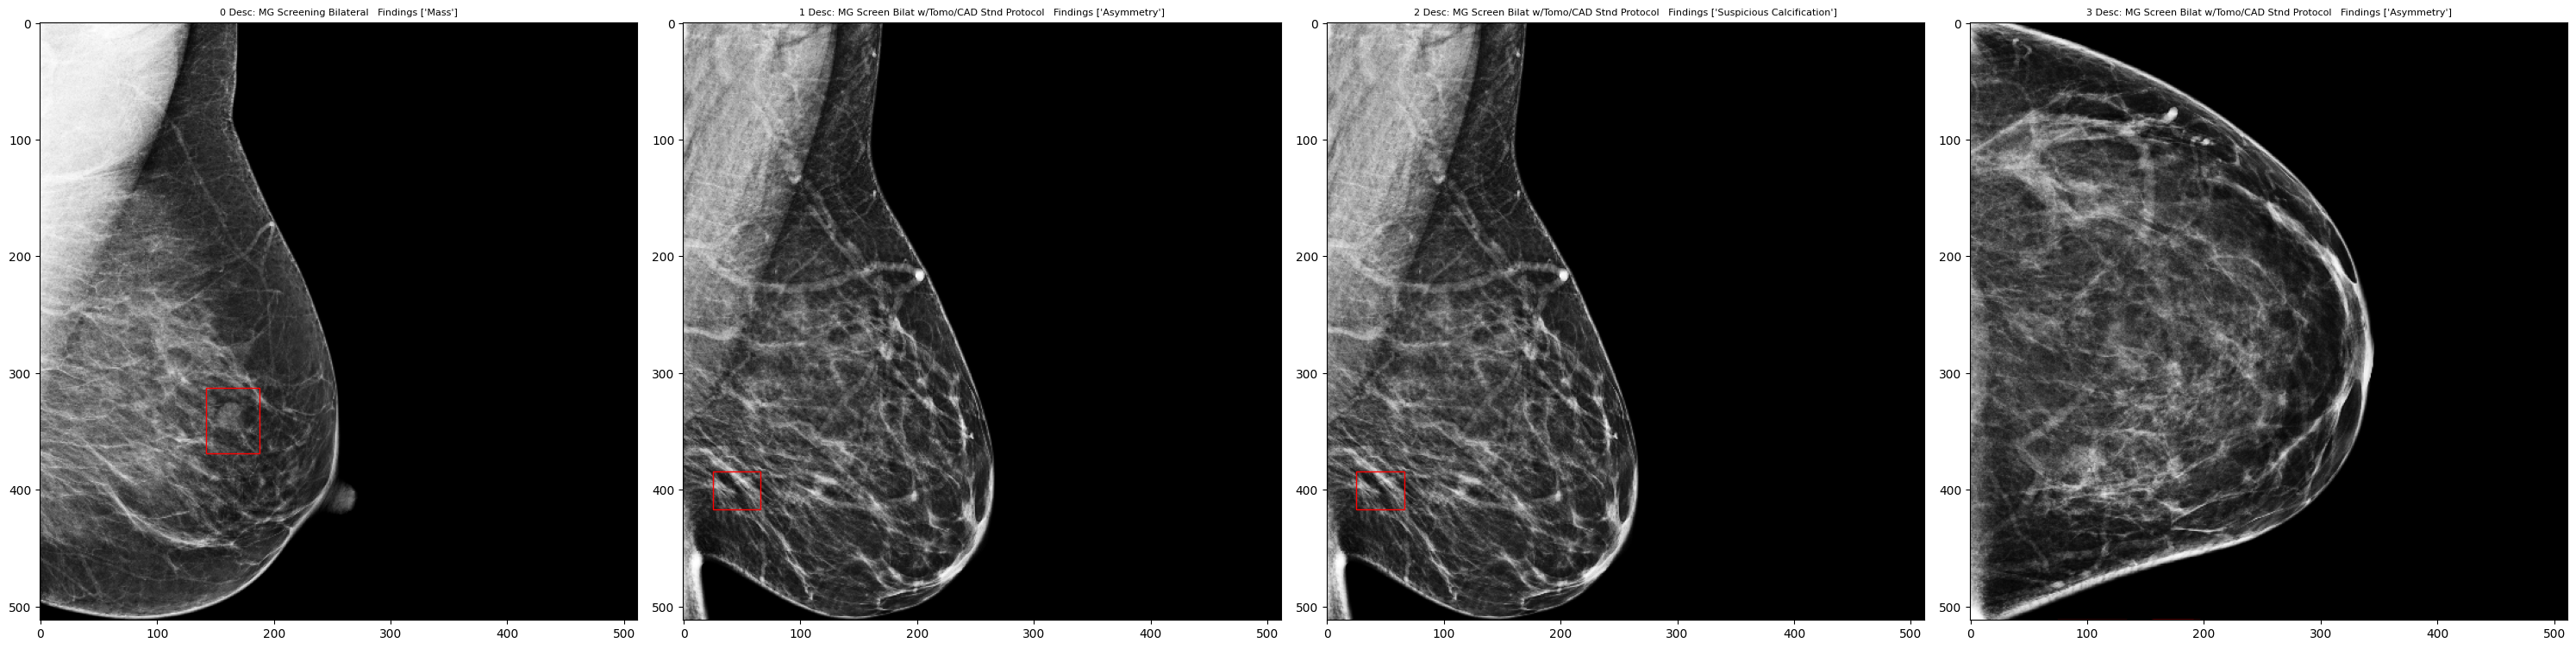

In [11]:
# idx =  random.sample(range(find_emory.shape[0]), 4)
display_image_transform(find_emory, idx)

In [12]:
find_emory['category'].value_counts()

category
Asymmetry                   139
Suspicious Calcification     80
Mass                         31
Architectural distortion     15
Name: count, dtype: int64

In [13]:
train_data = find_emory[find_emory['category']!='Architectural distortion'].reset_index()

In [14]:
cat_map = {k:list(train_data['category'].unique()).index(k) for k in train_data['category'].unique()}
cat_map

{'Suspicious Calcification': 0, 'Mass': 1, 'Asymmetry': 2}

In [15]:
train_data['category'] = train_data['category'].map(cat_map)

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train, val = train_test_split(train_data, test_size=0.1, stratify=train_data['category'])

In [18]:
train, val = train.reset_index(drop=True), val.reset_index(drop=True)

In [31]:
train = train.drop([58],axis=0).reset_index(drop=True)

In [60]:
os.makedirs('emory_yolo/train/images', exist_ok=True)
os.makedirs('emory_yolo/train/labels', exist_ok=True)

os.makedirs('emory_yolo/val/images', exist_ok=True)
os.makedirs('emory_yolo/val/labels', exist_ok=True)

In [61]:
def get_bboxes_yolo(data, dst_path, label_path):
    for i, row in tqdm(enumerate(data.itertuples()), desc="Getting BBoxes.."):
        
        img_file_path = row.image_path
        if os.path.exists(img_file_path):
            
            try:
                img_np = cv2.imread(img_file_path, cv2.IMREAD_GRAYSCALE)
            
                img_torch = torch.from_numpy(img_np).to(torch.float32)
                img_torch = mean_variance_normalization(img_torch)
                # Extract the breast region
                image_data = torch_ExtractBreast_with_padding_single_side(img_torch, padding=0)

                # Convert the result back to a NumPy array for visualization or further processing
                padded_img_np = image_data['padded_img'].cpu().numpy().astype(np.uint8)
                padded_img_rgb = np.repeat(padded_img_np[:, :, np.newaxis], 3, axis=2)
                padded_image = Image.fromarray(padded_img_rgb)

                dst_img_path = os.path.join(dst_path, f"{row.image_path.split('/')[-1]}")
                padded_image.save(dst_img_path)

                label_file_path = os.path.join(label_path, f"{row.image_path.split('/')[-1].replace('.png','.txt')}")
                width, height = padded_image.size

                for roi in ast.literal_eval(row.ROI_coords):
                    y1, x1, y2, x2 = roi
                    # print(f"OLD ROI: x1:{x1}, y1:{y1}, x2:{x2}, y2:{y2}")
                    adj_roi=transform_bbox((x1, y1, x2, y2), image_data)
                    x1, y1, x2, y2 = adj_roi
                    # print(f"ADJ ROI: x1:{x1}, y1:{y1}, x2:{x2}, y2:{y2}")

                    x_center = ((x1 + x2) / 2) / width
                    y_center = ((y1 + y2) / 2) / height
                    wid = (x2 - x1) / width
                    hei = (y2 - y1) / height
                    
                    # print(f"YOLO FORMAT: category:{row.category}, x_center:{x_center}, y_center:{y_center}, wid:{wid}, hei:{hei}\n")

                    text = [row.category, x_center, y_center, wid, hei]
                    with open(label_file_path, 'w') as f:
                        text = [str(i) for i in text]
                        f.write(' '.join(text))
            except Exception as e:
                print(f"Cannot open File {img_file_path}")
                continue
        else:
            print(f"FILE NOT FOUND {img_file_path}")
                 
get_bboxes_yolo(train, dst_path="emory_yolo/train/images", label_path="emory_yolo/train/labels")
get_bboxes_yolo(val,  dst_path="emory_yolo/val/images", label_path="emory_yolo/val/labels")

Getting BBoxes..: 0it [00:00, ?it/s]

Getting BBoxes..: 0it [00:00, ?it/s]

Cannot open File emory/images_png/16168291/1.2.845.113682.2750824972.1550469931.4661.2139.1/38180941880001850727199742295180123832.png


In [62]:
data = dict(
    train = "/notebooks/emory_yolo/train/images",
    val = "/notebooks/emory_yolo/val/images",

    nc = len(cat_map),
    names = list(cat_map.keys())
)

with open('emory_yolo/data.yaml', 'w') as outfile:
    yaml.dump(data, outfile)

In [63]:
from ultralytics import YOLO
model = YOLO('yolov8s.pt')

In [ ]:
yaml_file = 'emory_yolo/data.yaml'

model.train(data=yaml_file,
            epochs=50,
            patience=10,
            batch=4,
            optimizer='Adam',
            lr0 = 1e-4,
            lrf = 1e-3,
            weight_decay = 5e-4,
            name = f'yolov8s_3classes',
            save=True,
            amp=True,
            val=True)

In [ ]:
# Define the path to the directory
post_training_files_path = 'runs/detect/yolov8s_3classes7'

# Construct the path to the best model weights file using os.path.join
best_model_path = os.path.join(post_training_files_path, 'weights/best.pt')

# Load the best model weights into the YOLO model
best_model = YOLO(best_model_path)

# Validate the best model using the validation set with default parameters
metrics = best_model.val(split='val')

In [66]:
# Convert the dictionary to a pandas DataFrame and use the keys as the index
metrics = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])

In [ ]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#9b63b8'}, style='darkgrid')

def display_images(post_training_files_path, image_files):
    
    for image_file in image_files:
        image_path = os.path.join(post_training_files_path, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(10, 10), dpi=120)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# List of image files to display
image_files = [
    'confusion_matrix_normalized.png',
    'F1_curve.png',
    'P_curve.png',
    'R_curve.png',
    'PR_curve.png',
    'results.png'
]

# Display the images
display_images(post_training_files_path, image_files)